# GAT Models to Compute Heritage Values and Attributes

## Imports

In [1]:
import torch

In [2]:
print(torch.__version__)

1.10.2


In [3]:
import os
import os.path as osp
from itertools import product
from typing import Callable, List, Optional

import numpy as np
import scipy.sparse as sp

from torch_geometric.data import (
    HeteroData,
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)

In [4]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import pandas as pd

import random

import torch
torch.manual_seed(1337)
torch.backends.cudnn.benchmark = True

from torch_geometric.transforms import RandomLinkSplit, ToUndirected
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear, to_hetero
from torch_geometric.utils import to_undirected

import torch.nn.functional as F
from torch_geometric import seed_everything

from tqdm import tqdm
import torch.optim as optim
import pickle

In [5]:
#from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GATConv
from torch_cluster import knn_graph

In [6]:
os.getcwd()

'D:\\surf\\TUD\\Paper\\Venice_Graph'

In [7]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2
GPU-enabled installation? True


In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [9]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [10]:
args = Namespace(
    # Data and Path information
    path = 'dataset/Venice',
    save_dir='model_storage/GAT/',
    model_state_file='model.pth',
    
    # Model hyper parameters
    hidden_channels = 256,
    num_layers = 3,
    num_heads = 2,
    k=3,
    use_gdc=True,
    
    # Training hyper parameters
    sample_nodes = 25,
    batch_size=32,
    early_stopping_criteria=100,
    learning_rate=0.0001,
    l2=2e-4,
    dropout_p=0.1,
    num_epochs=1000,
    seed=42,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [11]:
if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# handle dirs
handle_dirs(args.save_dir)    

Expanded filepaths: 
	model_storage/GAT/model.pth


## Constructing Dataset

In [11]:
class VEN(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (1,190 nodes), nodes with both visual and textual
    features 'vis_tex' (1,761 nodes) and four types of links - social similarity
    'SOC' (488,103 links), spatial similarity (445,779 links), temporal similarity
    (501,191 links), and simple composed link (1,071,977 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [12]:
class VEN_Homo(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_Homo is a homogeneous graph containing 2951 nodes and 1,071,977 links.
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data.edge_index = torch.stack([row, col], dim=0)
                data.edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [18]:
class VEN_XL(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1QZ5tyUWs6jYjh7mJrsnpou76iy-vb0CA'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)
        
        data['all'].att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data['all'].val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))
        data['all'].node_type = node_type_idx

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [19]:
class VEN_XL_Homo(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data.edge_index = torch.stack([row, col], dim=0)
                data.edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [13]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.NormalizeFeatures()
dataset = VEN_Homo('dataset/Venice_homo')
data = dataset[0]

In [14]:
data.n_id = torch.arange(data.num_nodes)
data = data.to(device)
data

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 1071977], edge_attr=[1071977], n_id=[2951])

In [15]:
data.x

tensor([[1.2861, 0.3745, 1.1453,  ..., 1.0000, 0.0000, 0.0000],
        [0.3977, 0.1582, 0.3059,  ..., 1.0000, 0.0000, 0.0000],
        [0.5185, 0.5124, 1.3662,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.0124, 1.7083, 0.3258,  ..., 0.0000, 1.0000, 0.0000],
        [0.4402, 0.8374, 0.4974,  ..., 0.0000, 1.0000, 0.0000],
        [0.2102, 1.5535, 0.3352,  ..., 0.0000, 1.0000, 0.0000]],
       device='cuda:0')

## Data Loader for Sampling

In [16]:
from torch_geometric.loader import NeighborLoader

In [17]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [18]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [19]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [20]:
sampled_data = next(iter(train_loader))
batch = sampled_data
batch

Data(num_nodes=2942, x=[2942, 1753], y=[2942, 20], node_type=[2942], att_lab=[2942], val_lab=[2942], train_mask=[2942], val_mask=[2942], test_mask=[2942], edge_index=[2, 103612], edge_attr=[103612], n_id=[2942], batch_size=32)

In [21]:
batch['train_mask'].sum()

tensor(360, device='cuda:0')

In [22]:
batch.n_id[:32]

tensor([  1,  28,  30,  34,  35,  42,  46,  47,  62,  64,  94,  95, 100, 101,
        104, 106, 110, 120, 127, 151, 158, 160, 165, 178, 179, 199, 222, 245,
        251, 252, 260, 261], device='cuda:0')

In [23]:
batch.y.shape

torch.Size([2942, 20])

## Helper Function

In [24]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_ATT_acc_val': 0,
            'early_stopping_best_VAL_acc_val': 0,
            'early_stopping_best_ATT_acc_val_2': 0,
            'early_stopping_lowest_loss': 1000,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_ATT_loss': [],
            'train_VAL_loss':[],
            'train_ATT_acc': [],
            'train_VAL_acc': [],
            'train_VAL_jac': [],
            'train_VAL_acc_1':[], 
            'val_loss': [],
            'val_ATT_loss': [],
            'val_VAL_loss':[],
            'val_ATT_acc': [],
            'val_VAL_acc': [],
            'val_VAL_jac': [],
            'val_VAL_acc_1': [],
            'test_loss': -1,
            'test_ATT_loss': -1,
            'test_VAL_loss':-1,
            'test_ATT_acc': -1,
            'test_VAL_acc': -1,
            'test_VAL_jac': -1,
            'test_VAL_acc_1': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        ATT_acc_tm1, ATT_acc_t = train_state['val_ATT_acc'][-2:]
        #ATT_acc_2_tm1, ATT_acc_2_t = train_state['val_ATT_acc_2'][-2:]
        VAL_acc_tm1, VAL_acc_t = train_state['val_VAL_acc'][-2:]
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If accuracy worsened
        #if loss_t >= train_state['early_stopping_lowest_loss']:
        #    train_state['early_stopping_step'] += 1
        
        if ATT_acc_t <= train_state['early_stopping_best_ATT_acc_val'] and VAL_acc_t <= train_state['early_stopping_best_VAL_acc_val']:# and ATT_acc_2_t <= train_state['early_stopping_best_ATT_acc_val_2']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if VAL_acc_t > train_state['early_stopping_best_VAL_acc_val']:
                train_state['early_stopping_best_VAL_acc_val'] = VAL_acc_t
                
            if ATT_acc_t > train_state['early_stopping_best_ATT_acc_val']:
                train_state['early_stopping_best_ATT_acc_val'] = ATT_acc_t
            
            #if ATT_acc_2_t > train_state['early_stopping_best_ATT_acc_val_2']:
            #    train_state['early_stopping_best_ATT_acc_val_2'] = ATT_acc_2_t
                
            if loss_t < train_state['early_stopping_lowest_loss']:
                train_state['early_stopping_lowest_loss'] = loss_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [25]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [26]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

## Searched Best Hyper-parameter

In [129]:
with open(args.save_dir+'42/hyperdict.p', 'rb') as fp:
    hyperdict= pickle.load(fp)

In [130]:
len(hyperdict)

114

In [131]:
hyperdict.keys()

dict_keys([(0.1, 2, 32, 0.01), (0.1, 2, 32, 0.001), (0.1, 2, 32, 0.0001), (0.1, 2, 64, 0.01), (0.1, 2, 64, 0.001), (0.1, 2, 64, 0.0001), (0.1, 2, 128, 0.01), (0.1, 2, 128, 0.001), (0.1, 2, 128, 0.0001), (0.1, 2, 256, 0.01), (0.1, 2, 256, 0.001), (0.1, 2, 256, 0.0001), (0.1, 2, 512, 0.01), (0.1, 2, 512, 0.001), (0.1, 2, 512, 0.0001), (0.1, 5, 32, 0.01), (0.1, 5, 32, 0.001), (0.1, 5, 32, 0.0001), (0.1, 5, 64, 0.01), (0.1, 5, 64, 0.001), (0.1, 5, 64, 0.0001), (0.1, 5, 128, 0.01), (0.1, 5, 128, 0.001), (0.1, 5, 128, 0.0001), (0.1, 5, 256, 0.01), (0.1, 5, 256, 0.001), (0.1, 5, 256, 0.0001), (0.1, 5, 512, 0.01), (0.1, 5, 512, 0.001), (0.1, 5, 512, 0.0001), (0.1, 8, 32, 0.01), (0.1, 8, 32, 0.001), (0.1, 8, 32, 0.0001), (0.1, 8, 64, 0.01), (0.1, 8, 64, 0.001), (0.1, 8, 64, 0.0001), (0.1, 8, 128, 0.01), (0.1, 8, 128, 0.001), (0.1, 8, 128, 0.0001), (0.1, 8, 256, 0.01), (0.1, 8, 256, 0.001), (0.1, 8, 256, 0.0001), (0.3, 2, 32, 0.01), (0.3, 2, 32, 0.001), (0.3, 2, 32, 0.0001), (0.3, 2, 64, 0.01), 

In [132]:
hyper_df = pd.DataFrame(hyperdict).T

In [38]:
hyperdict[(0.1,8,128,0.001)]

{'stop_early': True,
 'early_stopping_step': 100,
 'early_stopping_best_ATT_acc_val': 86.33093525179856,
 'early_stopping_best_VAL_acc_val': 96.40287769784173,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 4.250159640792463,
 'learning_rate': 0.001,
 'epoch_index': 125,
 'train_loss': [4.115122119585673,
  3.487265487511953,
  3.1288148363431296,
  2.8914007544517517,
  2.700275182723999,
  2.626474976539612,
  2.6187708576520285,
  2.5704930623372397,
  2.5644010106722512,
  2.6033581495285034,
  2.593102812767029,
  2.555069386959076,
  2.542228897412618,
  2.585222144921621,
  2.545814832051595,
  2.5474761724472046,
  2.530776262283325,
  2.559297184149424,
  2.5298489928245544,
  2.5131618976593018,
  2.520117243131002,
  2.495916942755381,
  2.51517790555954,
  2.4745981891949973,
  2.4969033002853394,
  2.4866838653882346,
  2.4931185841560364,
  2.491485377152761,
  2.4887433449427285,
  2.4877787232398987,
  2.4769266843795776,
  2.5029664238293967,
 

In [133]:
hyper_df[(hyper_df.early_stopping_best_VAL_acc_val + hyper_df.early_stopping_best_VAL_acc_val)>196]

stop_early early_stopping_step  \
0.1 2 128 0.0010       True                 100   
    5 32  0.0001       True                 100   
      512 0.0001       True                 100   
    8 32  0.0100       True                 100   
0.3 2 128 0.0010       True                 100   
    5 32  0.0100       True                 100   
    8 64  0.0100       True                 100   

                 early_stopping_best_ATT_acc_val  \
0.1 2 128 0.0010                       90.071942   
    5 32  0.0001                       90.071942   
      512 0.0001                       90.935252   
    8 32  0.0100                       88.057554   
0.3 2 128 0.0010                       88.345324   
    5 32  0.0100                       85.611511   
    8 64  0.0100                       87.769784   

                 early_stopping_best_VAL_acc_val  \
0.1 2 128 0.0010                       98.129496   
    5 32  0.0001                       98.417266   
      512 0.0001                       98.848921   
    8 32  0.0100                       98.848921   
0.3 2 128 0.0010                       98.129496   
    5 32  0.0100                       98.273381   
    8 64  0.0100                       98.129496   

                 early_stopping_best_ATT_acc_val_2 early_stopping_lowest_loss  \
0.1 2 128 0.0010                                 0                   4.161721   
    5 32  0.0001                                 0                   4.151279   
      512 0.0001                                 0                   4.142859   
    8 32  0.0100                                 0                   4.230725   
0.3 2 128 0.0010                                 0                   4.173171   
    5 32  0.0100                                 0                   4.316985   
    8 64  0.0100                                 0                   4.318487   

                 learning_rate epoch_index  \
0.1 2 128 0.0010         0.001         194   
    5 32  0.0001        0.0001         450   
      512 0.0001        0.0001         241   
    8 32  0.0100          0.01         250   
0.3 2 128 0.0010         0.001         282   
    5 32  0.0100          0.01         342   
    8 64  0.0100          0.01         412   

                                                         train_loss  \
0.1 2 128 0.0010  [3.749527335166931, 3.1979790131251016, 2.8717...   
    5 32  0.0001  [4.2933124502499895, 3.8550999959309897, 3.717...   
      512 0.0001  [3.853951096534729, 3.6204877694447837, 3.3742...   
    8 32  0.0100  [8.748551845550537, 3.861710508664449, 3.47437...   
0.3 2 128 0.0010  [3.745348811149597, 3.177211801211039, 2.85880...   
    5 32  0.0100  [7.232279658317566, 3.786673982938131, 3.27010...   
    8 64  0.0100  [12.568278908729553, 6.387039542198181, 4.4356...   

                                                     train_ATT_loss  ...  \
0.1 2 128 0.0010  [1.7099867015664267, 1.3311545033203929, 1.054...  ...   
    5 32  0.0001  [1.983609967945025, 1.8928287551013387, 1.8518...  ...   
      512 0.0001  [1.8365001850181009, 1.742488514023144, 1.5668...  ...   
    8 32  0.0100  [5.154336715338963, 4.724637833328458, 5.21760...  ...   
0.3 2 128 0.0010  [1.729639697273022, 1.2917713636836847, 1.0431...  ...   
    5 32  0.0100  [3.9959895993864105, 5.370007290404259, 8.0130...  ...   
    8 64  0.0100  [8.291277605410759, 3.3177685050753016, 3.9909...  ...   

                                                        val_VAL_acc  \
0.1 2 128 0.0010  [94.38848920863309, 90.79136690647482, 78.2733...   
    5 32  0.0001  [35.10791366906475, 68.05755395683454, 82.8776...   
      512 0.0001  [85.32374100719424, 94.96402877697842, 86.1870...   
    8 32  0.0100  [57.410071942446045, 76.83453237410072, 76.978...   
0.3 2 128 0.0010  [60.28776978417266, 90.2158273381295, 66.04316...   
    5 32  0.0100  [34.24460431654676, 34.24460431654676, 80.8633...   
    8 64  0.0100  [81.00719424460432, 34.24460431654676, 77.6978...   

         

In [139]:
hyper_df[(hyper_df.early_stopping_lowest_loss<4.14)]

stop_early early_stopping_step  \
0.1 2 32  0.0001       True                 246   
      64  0.0001       True                 372   
      256 0.0001       True                 100   
    5 32  0.0010       True                 100   
      64  0.0010       True                 100   
      128 0.0001       True                 100   

                 early_stopping_best_ATT_acc_val  \
0.1 2 32  0.0001                       91.366906   
      64  0.0001                       91.223022   
      256 0.0001                       90.791367   
    5 32  0.0010                       90.791367   
      64  0.0010                       90.215827   
      128 0.0001                       90.647482   

                 early_stopping_best_VAL_acc_val  \
0.1 2 32  0.0001                       92.661871   
      64  0.0001                       97.697842   
      256 0.0001                       97.122302   
    5 32  0.0010                       95.827338   
      64  0.0010                       91.942446   
      128 0.0001                       97.841727   

                 early_stopping_best_ATT_acc_val_2 early_stopping_lowest_loss  \
0.1 2 32  0.0001                                 0                   4.138368   
      64  0.0001                                 0                   4.139587   
      256 0.0001                                 0                   4.132101   
    5 32  0.0010                                 0                   4.138736   
      64  0.0010                                 0                   4.139871   
      128 0.0001                                 0                   4.138529   

                 learning_rate epoch_index  \
0.1 2 32  0.0001        0.0001         999   
      64  0.0001        0.0001         999   
      256 0.0001        0.0001         311   
    5 32  0.0010         0.001         432   
      64  0.0010         0.001         209   
      128 0.0001        0.0001         535   

                                                         train_loss  \
0.1 2 32  0.0001  [4.324005583922069, 4.024964610735576, 3.84491...   
      64  0.0001  [4.118880391120911, 3.7441560427347818, 3.6038...   
      256 0.0001  [3.99049578110377, 3.564414660135905, 3.452611...   
    5 32  0.0010  [3.88113001982371, 3.507416069507599, 3.287329...   
      64  0.0010  [3.867542048295339, 3.36818265914917, 3.088464...   
      128 0.0001  [4.0143164197603864, 3.616700828075409, 3.5310...   

                                                     train_ATT_loss  ...  \
0.1 2 32  0.0001  [2.0784328353702195, 1.978809388720758, 1.9042...  ...   
      64  0.0001  [1.9698226494802333, 1.8714637346875305, 1.814...  ...   
      256 0.0001  [1.8507629979680449, 1.7754817012274364, 1.683...  ...   
    5 32  0.0010  [1.8174761467693255, 1.6012966916831908, 1.449...  ...   
      64  0.0010  [1.8341679361718513, 1.471865924771803, 1.2299...  ...   
      128 0.0001  [1.8767330029004168, 1.8049459582880925, 1.726...  ...   

                                                        val_VAL_acc  \
0.1 2 32  0.0001  [75.53956834532374, 46.330935251798564, 45.035...   
      64  0.0001  [80.14388489208633, 90.50359712230215, 86.3309...   
      256 0.0001  [86.4748201438849, 88.92086330935251, 61.15107...   
    5 32  0.0010  [65.61151079136691, 62.87769784172662, 73.0935...   
      64  0.0010  [55.25179856115108, 91.94244604316546, 81.5827...   
      128 0.0001  [52.23021582733813, 81.87050359712231, 80.4316...   

                                                        val_VAL_jac test_loss  \
0.1 2 32  0.0001  [0.1282733869209564, 0.1447721822656316, 0.133...        -1   
      64  0.0001  [0.13347722231912956, 0.13347722231912956, 0.1...        -1   
      256 0.0001  [0.13347722231912956, 0.13347722231912956, 0.1...        -1   
    5 32  0.0010  [0.13347722231912956, 0.13304556736843193, 0.1...        -1   
      64  0.0010  [0.13354916435351474, 0.1382494013944118, 0.13...        -1   
      128 0.0001  [0.13

In [150]:
(hyper_df['val_VAL_loss'].apply(lambda x: min(x)) + hyper_df['val_ATT_loss'].apply(lambda x: min(x))).index[11]

(0.1, 2, 256, 0.0001)

## Re-run model and get Inference Data

In [27]:
class GAT_L(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads, dropout):
        super().__init__()
        self.p = dropout
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=dropout)
        # On the Pubmed dataset, use `heads` output heads in `conv2`.
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1,
                             concat=False, dropout=dropout)
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.p, training=self.training)
        x_0 = self.lin1(x).relu()
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin2(torch.hstack([x_0,x]))
        return x

In [27]:
def train_Homo(model, optimizer, train_loader):
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = args.batch_size
        edge_index = to_undirected(batch.edge_index)
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]
        
        loss = F.cross_entropy(out_att, y_att[:batch_size]) + F.cross_entropy(out_val, y_val[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [28]:
@torch.no_grad()
def test_Homo(model, loader):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_1_val = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch.att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch.val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]
    
    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [30]:
def initialization():
    set_seed_everywhere(args.seed, args.cuda)
    #transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_Homo('dataset/Venice_homo')
    data = dataset[0]
    data.n_id = torch.arange(data.num_nodes)
    data = data.to(device)
    
    train_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling training nodes
        batch_size=args.batch_size,
        input_nodes=data.train_mask,
    )
    val_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling validating nodes
        batch_size=args.batch_size,
        input_nodes=data.val_mask,
    )
    test_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling testing nodes
        batch_size=args.batch_size,
        input_nodes=data.test_mask,
    )
 
    model = GAT_L(in_channels=data.x.shape[-1], hidden_channels = 256, 
            out_channels = data.y.shape[-1], dropout = 0.1, heads=2).to(device)
    return data, model, train_loader, val_loader, test_loader

In [31]:
def training_loop(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train_Homo(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test_Homo(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test_Homo(model, val_loader)
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [ ]:
train_state = training_loop(verbose=True)

In [29]:
model = GAT_L(dataset.num_features, 256, dataset.num_classes,
            heads=2, dropout=.1).to(device)

In [30]:
model.load_state_dict(torch.load(args.save_dir+'GAT_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [31]:
model

GAT_L(
  (conv1): GATConv(1753, 256, heads=2)
  (conv2): GATConv(512, 256, heads=1)
  (lin1): Linear(1753, 256, bias=True)
  (lin2): Linear(512, 20, bias=True)
)

In [55]:
set_seed_everywhere(args.seed, args.cuda)
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 25.78it/s]


In [56]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.81it/s]


(0.723601653470227,
 1.5968123238502778,
 100.0,
 100.0,
 0.8827331627504977,
 92.797783933518)

In [57]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 27.83it/s]


(0.8012134174748164,
 1.618552706511737,
 98.17073170731707,
 99.50738916256158,
 0.7619047658196811,
 80.29556650246306)

In [58]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.73it/s]


(0.8164416074041818,
 1.6323064925769966,
 97.21669980119285,
 99.47916666666667,
 0.7647569527228674,
 82.8125)

In [59]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 32.61it/s]


In [60]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [61]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.801250,1.618615,98.069106,99.507389,0.763218,80.394089
std,0.000132,0.000075,0.107123,0.000000,0.002263,0.452678
min,0.801060,1.618526,97.967480,99.507389,0.759442,79.802956
25%,0.801157,1.618573,97.967480,99.507389,0.761905,80.295567
50%,0.801229,1.618601,98.069106,99.507389,0.764368,80.295567
75%,0.801316,1.618619,98.170732,99.507389,0.764368,80.665025
max,0.801511,1.618778,98.170732,99.507389,0.766831,81.280788


In [62]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.816202,1.632337,97.375746,9.947917e+01,0.761111,82.552083
std,0.000146,0.000073,0.083824,1.497956e-14,0.003057,0.442623
min,0.815966,1.632191,97.216700,9.947917e+01,0.756944,81.770833
25%,0.816115,1.632289,97.415507,9.947917e+01,0.759549,82.291667
50%,0.816205,1.632367,97.415507,9.947917e+01,0.760851,82.552083
75%,0.816243,1.632390,97.415507,9.947917e+01,0.764106,82.812500
max,0.816471,1.632416,97.415507,9.947917e+01,0.764757,83.333333


In [63]:
val_df.to_csv(args.save_dir + 'val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'test_metrics.csv', sep='\t')

In [64]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [65]:
train_state

{'stop_early': True,
 'early_stopping_step': 100,
 'early_stopping_best_ATT_acc_val': 98.17073170731707,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.656711502732424,
 'learning_rate': 0.0001,
 'epoch_index': 441,
 'train_loss': [4.016014138857524,
  3.580979287624359,
  3.476141393184662,
  3.359775106112162,
  3.262439409891764,
  3.1556219458580017,
  3.0627198815345764,
  2.9832192262013755,
  2.894130051136017,
  2.8221245805422464,
  2.7742998798688254,
  2.710253198941549,
  2.663776616255442,
  2.6352937618891397,
  2.583137810230255,
  2.5726837515830994,
  2.550245145956675,
  2.5174156427383423,
  2.498042583465576,
  2.5006632804870605,
  2.483529508113861,
  2.469638546307882,
  2.4693893790245056,
  2.454873959223429,
  2.452928980191549,
  2.445686995983124,
  2.449835201104482,
  2.4269318183263144,
  2.441512187321981,
  2.4307491381963096,
  2.425937592983246,
  2.4177355766296387,
  2.41255835692

In [66]:
with open(args.save_dir+'GAT_best_model/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
with open(args.save_dir+'GAT_best_model/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [68]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [69]:
states

,val_VAL,train_VAL,val_ATT,train_ATT,val_VAL_1,train_VAL_1,train_VAL_jac,val_VAL_jac
0,86.699507,88.642659,37.195122,42.659280,59.605911,55.401662,0.008310,0.019704
1,92.118227,94.459834,37.195122,40.997230,64.039409,61.495845,0.288089,0.321018
2,94.088670,94.736842,46.138211,54.570637,68.472906,61.772853,0.453370,0.545977
3,98.029557,96.675900,50.000000,61.772853,72.906404,65.096953,0.511542,0.586207
4,98.522167,97.506925,54.065041,67.036011,72.906404,66.204986,0.565097,0.634647
...,...,...,...,...,...,...,...,...
437,99.507389,100.000000,97.357724,100.000000,80.295567,92.797784,0.892428,0.757800
438,99.507389,100.000000,97.560976,100.000000,79.802956,93.905817,0.902124,0.758621
439,99.507389,100.000000,96.544715,100.000000,79.802956,94.736842,0.902124,0.767652
440,99.507389,100.000000,97.154472,100.000000,80.295567,92.797784,0.884580,0.757800


In [70]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<AxesSubplot:>

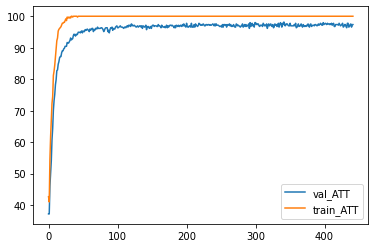

In [71]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

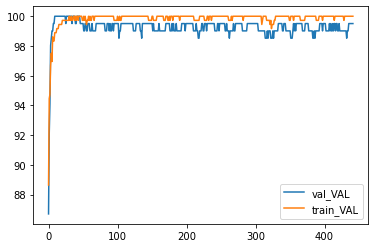

In [72]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

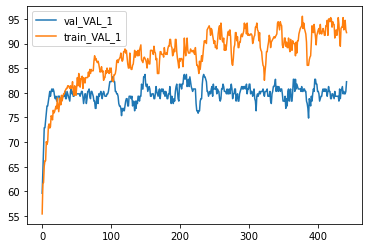

In [73]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

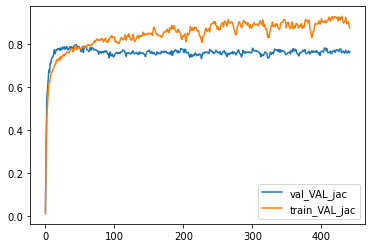

In [74]:
states[['val_VAL_jac','train_VAL_jac']].plot()

In [75]:
train_state['train_loss']

[4.016014138857524,
 3.580979287624359,
 3.476141393184662,
 3.359775106112162,
 3.262439409891764,
 3.1556219458580017,
 3.0627198815345764,
 2.9832192262013755,
 2.894130051136017,
 2.8221245805422464,
 2.7742998798688254,
 2.710253198941549,
 2.663776616255442,
 2.6352937618891397,
 2.583137810230255,
 2.5726837515830994,
 2.550245145956675,
 2.5174156427383423,
 2.498042583465576,
 2.5006632804870605,
 2.483529508113861,
 2.469638546307882,
 2.4693893790245056,
 2.454873959223429,
 2.452928980191549,
 2.445686995983124,
 2.449835201104482,
 2.4269318183263144,
 2.441512187321981,
 2.4307491381963096,
 2.425937592983246,
 2.4177355766296387,
 2.412558356920878,
 2.414771775404612,
 2.420555830001831,
 2.4095747470855713,
 2.417506297429403,
 2.4048957228660583,
 2.4012410243352256,
 2.4133909344673157,
 2.4146655797958374,
 2.4124674002329507,
 2.395471533139547,
 2.4041011730829873,
 2.373327632745107,
 2.4147808949152627,
 2.40478777885437,
 2.3814737200737,
 2.4040048917134604,
 

In [76]:
batch

Data(num_nodes=2917, x=[2917, 1753], y=[2917, 20], node_type=[2917], att_lab=[2917], val_lab=[2917], train_mask=[2917], val_mask=[2917], test_mask=[2917], edge_index=[2, 104789], edge_attr=[104789], n_id=[2917], batch_size=32)

In [77]:
unlabel_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data.train_mask + data.val_mask + data.test_mask),
)

In [78]:
@torch.no_grad()
def predict_Homo(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch.n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [79]:
pred_train = predict_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 38.10it/s]


In [80]:
pred_val = predict_Homo(model, val_loader)
pred_test = predict_Homo(model, test_loader)
pred_unlab = predict_Homo(model, unlabel_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.84it/s]


In [81]:
(~(data.train_mask + data.val_mask + data.test_mask))

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [82]:
pred_train[0]

tensor([1.0000e+00, 6.6071e-03, 2.1020e-02, 2.2766e-03, 1.5532e-03, 2.4628e-02,
        4.3376e-02, 3.7304e-03, 8.8654e-04, 8.9592e-01, 1.3337e-01, 4.0112e-01,
        2.2467e-01, 1.0778e-01, 1.4155e-02, 9.7556e-02, 3.3932e-03, 2.8701e-03,
        3.1890e-03, 3.6642e-03, 8.2425e-03], device='cuda:0')

In [83]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [84]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [85]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [86]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.019247,0.094892,0.009801,0.005316,0.135843,0.116122,0.042467,0.005333,0.570979,0.074326,0.313263,0.238476,0.239006,0.016720,0.098719,0.003096,0.002180,0.002781,0.002974,0.008460
1.0,0.006607,0.021020,0.002277,0.001553,0.024628,0.043376,0.003730,0.000887,0.895922,0.133369,0.401117,0.224667,0.107776,0.014155,0.097556,0.003393,0.002870,0.003189,0.003664,0.008243
2.0,0.036314,0.079916,0.020602,0.013223,0.150390,0.320887,0.083175,0.012250,0.283245,0.163897,0.295154,0.228652,0.152374,0.013412,0.122542,0.004595,0.003285,0.003033,0.003729,0.009327
3.0,0.042081,0.198455,0.034115,0.011695,0.009535,0.086096,0.553848,0.049560,0.014615,0.070768,0.037889,0.176445,0.077414,0.032098,0.568712,0.009925,0.005847,0.004499,0.006272,0.010132
4.0,0.280098,0.327038,0.008397,0.075238,0.008564,0.235872,0.043952,0.010466,0.010376,0.202305,0.081352,0.092840,0.221243,0.011949,0.365854,0.005850,0.003704,0.002659,0.002941,0.009303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.016753,0.457933,0.130361,0.021919,0.002812,0.020500,0.273795,0.057261,0.018667,0.334646,0.197165,0.211783,0.165527,0.018890,0.041695,0.004684,0.003745,0.004047,0.005722,0.012095
2947.0,0.001878,0.025765,0.272693,0.012658,0.001383,0.002242,0.597483,0.080397,0.005501,0.301580,0.156060,0.265921,0.186380,0.017666,0.045506,0.003548,0.003296,0.003328,0.005876,0.010839
2948.0,0.066828,0.569370,0.066741,0.023436,0.008628,0.032728,0.167500,0.051949,0.012819,0.320929,0.209535,0.205743,0.173799,0.022401,0.033467,0.005918,0.005149,0.005105,0.005922,0.012032


In [87]:
preds_df.to_csv(args.save_dir + 'preds.csv', sep='\t')

In [88]:
states.to_csv(args.save_dir + 'train_state.csv', sep='\t')

## Per-Class Metrics

In [89]:
from sklearn.metrics import confusion_matrix

In [90]:
preds = pd.read_csv(args.save_dir + 'preds.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.019247,0.094892,0.009801,0.005316,0.135843,0.116122,0.042467,0.005333,0.570979,0.074326,0.313263,0.238476,0.239006,0.016720,0.098719,0.003096,0.002180,0.002781,0.002974,0.008460
1.0,0.006607,0.021020,0.002277,0.001553,0.024628,0.043376,0.003730,0.000887,0.895922,0.133369,0.401117,0.224667,0.107776,0.014155,0.097556,0.003393,0.002870,0.003189,0.003664,0.008243
2.0,0.036314,0.079916,0.020602,0.013223,0.150390,0.320887,0.083175,0.012250,0.283245,0.163897,0.295154,0.228652,0.152374,0.013412,0.122542,0.004595,0.003285,0.003033,0.003729,0.009327
3.0,0.042081,0.198455,0.034115,0.011695,0.009535,0.086096,0.553848,0.049560,0.014615,0.070768,0.037889,0.176445,0.077414,0.032098,0.568712,0.009925,0.005847,0.004499,0.006272,0.010132
4.0,0.280098,0.327038,0.008397,0.075238,0.008564,0.235872,0.043952,0.010466,0.010376,0.202305,0.081352,0.092840,0.221243,0.011949,0.365854,0.005850,0.003704,0.002659,0.002941,0.009303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.016753,0.457933,0.130361,0.021919,0.002812,0.020500,0.273795,0.057261,0.018667,0.334646,0.197165,0.211783,0.165527,0.018890,0.041695,0.004684,0.003745,0.004047,0.005722,0.012095
2947.0,0.001878,0.025765,0.272693,0.012658,0.001383,0.002242,0.597483,0.080397,0.005501,0.301580,0.156060,0.265921,0.186380,0.017666,0.045506,0.003548,0.003296,0.003328,0.005876,0.010839
2948.0,0.066828,0.569370,0.066741,0.023436,0.008628,0.032728,0.167500,0.051949,0.012819,0.320929,0.209535,0.205743,0.173799,0.022401,0.033467,0.005918,0.005149,0.005105,0.005922,0.012032


In [91]:
pred = torch.tensor(np.array(preds)).to(device)

In [92]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [93]:
test_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
test_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.test_mask][:,9:].cpu(),3)).astype(int)

In [94]:
test_ATT_conf

array([[ 64,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 144,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,  10,   0,   0,   0,   0,   1,   0],
       [  2,   0,   0,  16,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,  71,   0,   0,   0,   0],
       [  0,   2,   0,   0,   0, 100,   0,   0,   0],
       [  0,   2,   0,   0,   2,   0,  73,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  12]], dtype=int64)

In [95]:
test_VAL_conf

array([[54,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3, 19,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  5, 20,  3,  0,  5,  0,  0,  0,  0,  0],
       [ 1,  0,  2, 28,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  3,  1,  0, 36,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [96]:
test_VAL_conf_k

array([[ 90,  54,  47,  43,   0,  48,   0,   0,   0,   0,   0],
       [ 50,  85,  73,  60,   0,  41,   0,   0,   0,   0,   0],
       [ 54,  79, 116,  88,   0,  70,   1,   0,   0,   0,   0],
       [ 55,  73,  89, 117,   0,  65,   0,   0,   0,   0,   0],
       [  0,   3,   3,   3,   0,   0,   0,   0,   0,   0,   0],
       [ 45,  36,  70,  70,   0,  87,   1,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   2,   2,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   1,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [97]:
val_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu(), 
                                pred[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.val_mask][:,9:].cpu(),3)).astype(int)

In [98]:
val_ATT_conf

array([[ 59,   1,   0,   0,   0,   1,   0,   0,   0],
       [  1, 144,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,  21,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  75,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 103,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,  61,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   3,   0],
       [  0,   1,   0,   0,   1,   0,   0,   0,   8]], dtype=int64)

In [99]:
val_VAL_conf

array([[65,  1,  2,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  9,  2,  5,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0, 24,  3,  0,  4,  0,  0,  0,  0,  0],
       [ 1,  1,  0, 31,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7,  4,  4,  1,  0, 34,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [100]:
val_VAL_conf_k

array([[103,  51,  61,  57,   0,  52,   0,   0,   0,   0,   0],
       [ 58,  83,  63,  71,   3,  43,   0,   0,   0,   0,   0],
       [ 53,  48, 120,  87,   0,  85,   0,   0,   0,   0,   0],
       [ 65,  71, 102, 118,   3,  67,   0,   0,   0,   0,   0],
       [  0,   8,   5,   8,   3,   0,   0,   0,   0,   0,   0],
       [ 48,  36,  90,  67,   0,  98,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [101]:
pd.concat([pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT.csv')
pd.concat([pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL.csv')
pd.concat([pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k.csv')

In [102]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [103]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [104]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [105]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [106]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [107]:
metrics_df.to_csv(args.save_dir+'per_class_metrics.csv')

## Explanation

In [32]:
from torch_geometric.nn import GNNExplainer

In [37]:
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')

In [38]:
def explain_features(model, loader):
    model.eval()
    seed_everything(args.seed)
    explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
    all_preds = {}
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        for node_idx in tqdm(range(batch_size)):
            node_feat_mask, _ = explainer.explain_node(node_idx, batch.x, edge_index)
            all_preds[batch.n_id[node_idx]] = node_feat_mask
    
    out = torch.vstack([torch.hstack([i, all_preds[i]]) for i in all_preds.keys()])
    return out

In [ ]:
train_explain = explain_features(model, train_loader)

In [ ]:
val_explain = explain_features(model, val_loader)

In [ ]:
test_explain = explain_features(model, test_loader)

In [42]:
len(train_explain)

361

In [43]:
len(test_explain)

695

In [44]:
train_explain_df = pd.DataFrame(train_explain.cpu()).sort_values(0).set_index(0)

In [45]:
val_explain_df = pd.DataFrame(val_explain.cpu()).sort_values(0).set_index(0)

In [46]:
test_explain_df = pd.DataFrame(test_explain.cpu()).sort_values(0).set_index(0)

In [47]:
all_explain_df = pd.concat([train_explain_df, val_explain_df, test_explain_df]).reset_index().rename(columns={0:'ID'})

In [48]:
all_explain_df['ID'] = all_explain_df['ID'].astype(int)

In [49]:
all_explain_df

,ID,1,2,3,4,5,6,7,8,9,...,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753
0,1,0.196204,0.125538,0.829300,0.143392,0.785905,0.712615,0.207511,0.859502,0.163500,...,0.156079,0.748273,0.176544,0.884632,0.872025,0.150538,0.121349,0.837967,0.172734,0.165242
1,28,0.827174,0.194986,0.172719,0.177570,0.845929,0.147856,0.840769,0.864428,0.818672,...,0.182639,0.885735,0.124151,0.852755,0.695044,0.854522,0.852328,0.157640,0.222541,0.857266
2,30,0.691643,0.848522,0.114636,0.353214,0.160089,0.834555,0.150483,0.319174,0.185085,...,0.595378,0.784241,0.736962,0.490071,0.190833,0.855286,0.818733,0.247251,0.848224,0.201359
3,34,0.081797,0.831367,0.194305,0.812363,0.825632,0.812793,0.174359,0.155627,0.843013,...,0.705959,0.845373,0.825102,0.529126,0.797624,0.228296,0.154702,0.144122,0.828859,0.158463
4,35,0.111419,0.843864,0.198652,0.799678,0.837694,0.840953,0.154347,0.174330,0.853294,...,0.794225,0.189007,0.818096,0.402568,0.834414,0.223977,0.119837,0.139210,0.132350,0.845993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,2931,0.159106,0.157753,0.809235,0.825924,0.159197,0.699754,0.208735,0.274189,0.154435,...,0.133370,0.306523,0.172947,0.130974,0.119893,0.154302,0.198281,0.157798,0.112518,0.194006
1747,2940,0.754659,0.843647,0.196224,0.774877,0.152437,0.838377,0.161009,0.186751,0.170173,...,0.146667,0.128474,0.163081,0.146479,0.138082,0.169267,0.134003,0.153524,0.173947,0.164563
1748,2944,0.129716,0.165112,0.354632,0.162761,0.140983,0.779570,0.120060,0.146458,0.752690,...,0.124579,0.208815,0.149776,0.856512,0.829717,0.829908,0.809690,0.115095,0.838183,0.152334
1749,2947,0.851133,0.199572,0.203811,0.165923,0.378331,0.161169,0.863782,0.885180,0.851160,...,0.819384,0.868243,0.195708,0.856170,0.232315,0.846350,0.180403,0.143601,0.826127,0.156721


In [50]:
all_explain_df.to_csv(args.save_dir + 'all_explain.csv', sep='\t')

In [51]:
train_explain_df.to_csv(args.save_dir + 'train_explain.csv', sep='\t')

In [20]:
all_explain_df = pd.read_csv(args.save_dir + 'all_explain.csv', sep='\t', index_col='Unnamed: 0')

In [26]:
train_explain_df = pd.read_csv(args.save_dir + 'train_explain.csv', sep='\t', index_col = '0')

In [27]:
train_explain_df

,1,2,3,4,5,6,7,8,9,10,...,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753
0,,,,,,,,,,,,,,,,,,,,,
1.0,0.196204,0.125538,0.829300,0.143392,0.785905,0.712615,0.207511,0.859502,0.163500,0.845775,...,0.156079,0.748273,0.176544,0.884632,0.872025,0.150538,0.121349,0.837967,0.172734,0.165242
28.0,0.827174,0.194986,0.172719,0.177570,0.845929,0.147856,0.840769,0.864428,0.818672,0.171176,...,0.182639,0.885735,0.124151,0.852755,0.695044,0.854522,0.852328,0.157639,0.222541,0.857266
30.0,0.691643,0.848522,0.114636,0.353214,0.160089,0.834555,0.150483,0.319174,0.185085,0.156366,...,0.595378,0.784241,0.736962,0.490071,0.190833,0.855286,0.818733,0.247251,0.848224,0.201359
34.0,0.081797,0.831367,0.194305,0.812363,0.825632,0.812793,0.174359,0.155627,0.843013,0.166483,...,0.705959,0.845373,0.825102,0.529126,0.797624,0.228296,0.154702,0.144122,0.828859,0.158463
35.0,0.111419,0.843864,0.198652,0.799678,0.837694,0.840953,0.154347,0.174330,0.853294,0.165892,...,0.794225,0.189007,0.818096,0.402568,0.834414,0.223977,0.119837,0.139210,0.132350,0.845993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874.0,0.450020,0.844422,0.133640,0.720120,0.173296,0.817665,0.135886,0.261146,0.162865,0.162220,...,0.205478,0.535880,0.134802,0.283869,0.143926,0.317814,0.848387,0.265529,0.859265,0.187919
2925.0,0.167516,0.186201,0.841639,0.824562,0.157850,0.172615,0.140802,0.211073,0.157474,0.860990,...,0.209529,0.257052,0.176212,0.472837,0.834740,0.192689,0.817822,0.174657,0.846631,0.158055
2927.0,0.812694,0.147226,0.172331,0.167961,0.380342,0.158814,0.832519,0.848071,0.859626,0.220389,...,0.820697,0.830039,0.176437,0.883862,0.273098,0.873988,0.185938,0.142743,0.867638,0.139545


In [21]:
all_explain_df

,ID,1,2,3,4,5,6,7,8,9,...,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753
0,1,0.196204,0.125538,0.829300,0.143392,0.785905,0.712615,0.207511,0.859502,0.163500,...,0.156079,0.748273,0.176544,0.884632,0.872025,0.150538,0.121349,0.837967,0.172734,0.165242
1,28,0.827174,0.194986,0.172719,0.177570,0.845929,0.147856,0.840769,0.864428,0.818672,...,0.182639,0.885735,0.124151,0.852755,0.695044,0.854522,0.852328,0.157639,0.222541,0.857266
2,30,0.691643,0.848522,0.114636,0.353214,0.160089,0.834555,0.150483,0.319174,0.185085,...,0.595378,0.784241,0.736962,0.490071,0.190833,0.855286,0.818733,0.247251,0.848224,0.201359
3,34,0.081797,0.831367,0.194305,0.812363,0.825632,0.812793,0.174359,0.155627,0.843013,...,0.705959,0.845373,0.825102,0.529126,0.797624,0.228296,0.154702,0.144122,0.828859,0.158463
4,35,0.111419,0.843864,0.198652,0.799678,0.837694,0.840953,0.154347,0.174330,0.853294,...,0.794225,0.189007,0.818096,0.402568,0.834414,0.223977,0.119837,0.139210,0.132350,0.845993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,2931,0.159106,0.157753,0.809235,0.825924,0.159197,0.699754,0.208735,0.274189,0.154435,...,0.133370,0.306523,0.172947,0.130974,0.119893,0.154302,0.198281,0.157798,0.112518,0.194006
1747,2940,0.754659,0.843647,0.196224,0.774877,0.152437,0.838377,0.161009,0.186751,0.170174,...,0.146667,0.128474,0.163081,0.146479,0.138082,0.169267,0.134003,0.153524,0.173947,0.164563
1748,2944,0.129716,0.165112,0.354632,0.162761,0.140983,0.779570,0.120060,0.146458,0.752690,...,0.124579,0.208815,0.149776,0.856512,0.829717,0.829908,0.809690,0.115095,0.838183,0.152334
1749,2947,0.851133,0.199572,0.203811,0.165923,0.378331,0.161169,0.863781,0.885180,0.851160,...,0.819384,0.868243,0.195708,0.856170,0.232315,0.846350,0.180403,0.143601,0.826127,0.156721


In [28]:
(all_explain_df>0.2).sum().

ID      1750
1        760
2        930
3        930
4       1327
        ... 
1749     795
1750     600
1751     485
1752     811
1753     300
Length: 1754, dtype: int64

In [29]:
feature_counts = pd.concat([(all_explain_df>0.2).sum().iloc[513:982],(all_explain_df>0.2).sum().iloc[1751:]])

In [36]:
thres = []
for i in range(20):
    thres.append((0.05*i, (((all_explain_df>(0.05*i)).sum().iloc[513:982])>0).sum()/len(feature_counts)))

In [39]:
167/472

0.3538135593220339

In [40]:
thres

[(0.0, 0.9936440677966102),
 (0.05, 0.9936440677966102),
 (0.1, 0.9936440677966102),
 (0.15000000000000002, 0.9936440677966102),
 (0.2, 0.336864406779661),
 (0.25, 0.336864406779661),
 (0.30000000000000004, 0.336864406779661),
 (0.35000000000000003, 0.336864406779661),
 (0.4, 0.336864406779661),
 (0.45, 0.336864406779661),
 (0.5, 0.3347457627118644),
 (0.55, 0.3347457627118644),
 (0.6000000000000001, 0.3347457627118644),
 (0.65, 0.3305084745762712),
 (0.7000000000000001, 0.3305084745762712),
 (0.75, 0.3220338983050847),
 (0.8, 0.3135593220338983),
 (0.8500000000000001, 0.19279661016949154),
 (0.9, 0.014830508474576272),
 (0.9500000000000001, 0.0)]

In [33]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [43]:
pd.DataFrame(thres)

,0,1
0,0.00,0.993644
1,0.05,0.993644
2,0.10,0.993644
3,0.15,0.993644
4,0.20,0.336864
5,0.25,0.336864
6,0.30,0.336864
7,0.35,0.336864
8,0.40,0.336864
9,0.45,0.336864


<AxesSubplot:xlabel='0'>

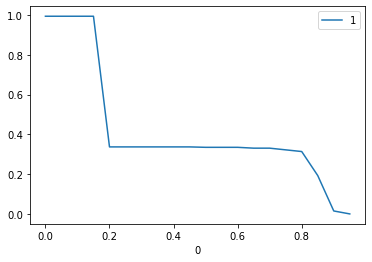

In [45]:
pd.DataFrame(thres).set_index(0).plot()

In [46]:
feature_counts

513     107
514      84
515      22
516       0
517       7
       ... 
980       0
981       0
1751    485
1752    811
1753    300
Length: 472, dtype: int64

In [47]:
feature_counts[feature_counts>0]

513     107
514      84
515      22
517       7
519     101
       ... 
974     172
976      11
1751    485
1752    811
1753    300
Length: 162, dtype: int64

In [48]:
feature_counts = feature_counts.sort_values(ascending=False)

In [49]:
feature_counts

1752    811
1751    485
970     428
969     411
595     350
       ... 
707       0
704       0
700       0
699       0
749       0
Length: 472, dtype: int64

<AxesSubplot:>

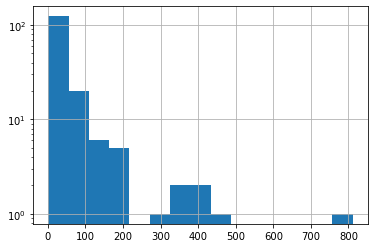

In [50]:
feature_counts[feature_counts>0].hist(log=True, bins=15)

In [51]:
(train_explain_df>0.5).sum().sort_values(ascending=False).head(20)

1616    360
1640    355
1360    355
1583    352
1294    343
1724    343
1552    342
1107    342
1450    342
1541    339
1551    339
1393    337
1298    336
1108    335
1540    333
1253    333
1561    333
1624    332
1405    327
1691    321
dtype: int64

In [249]:
batch

Data(num_nodes=2926, x=[2926, 1753], y=[2926, 20], node_type=[2926], train_mask=[2926], val_mask=[2926], test_mask=[2926], edge_index=[2, 101360], edge_attr=[101360], n_id=[2926], batch_size=32)

In [251]:
node_idx = 10
edge_index = to_undirected(batch.edge_index)
node_feat_mask, _ = explainer.explain_node(node_idx, batch.x, edge_index)
#ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
#plt.show()

Explain node 10: 100%|███████████████████████████████| 200/200 [00:07<00:00, 26.84it/s]


In [252]:
(node_feat_mask>0.9).sum()

tensor(7, device='cuda:0')

In [253]:
[i for i in range(len(node_feat_mask)) if node_feat_mask[i]>0.9]

[20, 28, 1152, 1254, 1474, 1552, 1567]

In [256]:
(node_feat_mask[515:982]>0.5)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

## TEM_links

In [112]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_tem('dataset/Venice_tem')
data = dataset[0]

Processing...
Done!


In [113]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [117]:
set_seed_everywhere(args.seed, args.cuda)
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 32.81it/s]


In [118]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.86it/s]


(0.7277005653302095,
 1.602298717089307,
 100.0,
 100.0,
 0.863342575749532,
 90.30470914127424)

In [119]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.84it/s]


(0.8052866606692958,
 1.62163168691062,
 97.96747967479675,
 99.50738916256158,
 0.7536945859786912,
 79.3103448275862)

In [120]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 40.39it/s]


(0.8224199704574069,
 1.6355466842651367,
 97.21669980119285,
 99.47916666666667,
 0.7473958457509676,
 81.77083333333333)

In [121]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 66.91it/s]


In [122]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [123]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,1.000000e+01,10.000000,10.000000,1.000000e+01
mean,0.805325,1.621630,9.796748e+01,99.507389,0.752709,7.980296e+01
std,0.000028,0.000008,1.497956e-14,0.000000,0.001272,1.497956e-14
min,0.805285,1.621613,9.796748e+01,99.507389,0.751232,7.980296e+01
25%,0.805303,1.621629,9.796748e+01,99.507389,0.751232,7.980296e+01
50%,0.805318,1.621633,9.796748e+01,99.507389,0.753695,7.980296e+01
75%,0.805350,1.621634,9.796748e+01,99.507389,0.753695,7.980296e+01
max,0.805366,1.621639,9.796748e+01,99.507389,0.753695,7.980296e+01


In [124]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,10.000000
mean,0.822416,1.635576,9.721670e+01,9.947917e+01,7.473958e-01,81.927083
std,0.000041,0.000012,1.497956e-14,1.497956e-14,1.170278e-16,0.251586
min,0.822341,1.635556,9.721670e+01,9.947917e+01,7.473958e-01,81.770833
25%,0.822396,1.635569,9.721670e+01,9.947917e+01,7.473958e-01,81.770833
50%,0.822418,1.635578,9.721670e+01,9.947917e+01,7.473958e-01,81.770833
75%,0.822445,1.635580,9.721670e+01,9.947917e+01,7.473958e-01,82.161458
max,0.822467,1.635598,9.721670e+01,9.947917e+01,7.473958e-01,82.291667


In [125]:
val_df.to_csv(args.save_dir + 'TEM_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'TEM_test_metrics_transfer.csv', sep='\t')

## SPA_links

In [126]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_spa('dataset/Venice_spa')
data = dataset[0]

Processing...
Done!


In [127]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [128]:
set_seed_everywhere(args.seed, args.cuda)
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 28.23it/s]


In [129]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 40.72it/s]


(0.7258908723860236,
 1.5998343060881808,
 100.0,
 100.0,
 0.8614958554423747,
 89.19667590027701)

In [130]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 31.80it/s]


(0.8021168802084961,
 1.6210297950970127,
 97.96747967479675,
 99.50738916256158,
 0.7430213542994607,
 80.78817733990148)

In [131]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 30.40it/s]


(0.815529429296376,
 1.6366863368699949,
 97.01789264413519,
 99.47916666666667,
 0.7482638930281004,
 82.8125)

In [133]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 39.66it/s]


In [134]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [135]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.802074,1.620901,97.947154,99.507389,0.744499,81.083744
std,0.000111,0.000025,0.064274,0.000000,0.002648,0.254383
min,0.801935,1.620861,97.764228,99.507389,0.740558,80.788177
25%,0.801982,1.620881,97.967480,99.507389,0.743021,80.788177
50%,0.802064,1.620902,97.967480,99.507389,0.745484,81.280788
75%,0.802153,1.620919,97.967480,99.507389,0.745484,81.280788
max,0.802264,1.620937,97.967480,99.507389,0.747947,81.280788


In [136]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.815570,1.636649,96.998012,9.947917e+01,0.746354,82.968750
std,0.000118,0.000055,0.062868,1.497956e-14,0.002196,0.251586
min,0.815445,1.636571,96.819085,9.947917e+01,0.743056,82.812500
25%,0.815489,1.636608,97.017893,9.947917e+01,0.744792,82.812500
50%,0.815545,1.636644,97.017893,9.947917e+01,0.746094,82.812500
75%,0.815603,1.636689,97.017893,9.947917e+01,0.748047,83.203125
max,0.815845,1.636737,97.017893,9.947917e+01,0.750000,83.333333


In [137]:
val_df.to_csv(args.save_dir + 'SPA_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SPA_test_metrics_transfer.csv', sep='\t')

## SOC_links

In [138]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_soc('dataset/Venice_soc')
data = dataset[0]

Processing...
Done!


In [139]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [140]:
set_seed_everywhere(args.seed, args.cuda)
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 31.59it/s]


In [141]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.53it/s]


(0.7273937661892159,
 1.6026624008559125,
 100.0,
 99.7229916897507,
 0.8559556839538743,
 87.25761772853186)

In [142]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.45it/s]


(0.8046205954823068,
 1.6253719611708166,
 97.96747967479675,
 99.01477832512315,
 0.7619047681686326,
 80.78817733990148)

In [143]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 37.60it/s]


(0.8232845396218196,
 1.6415579629441102,
 97.01789264413519,
 99.47916666666667,
 0.7465277885397276,
 80.72916666666667)

In [144]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 52.09it/s]


In [145]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [146]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,10.000000
mean,0.804516,1.625295,9.796748e+01,9.901478e+01,0.762644,79.950739
std,0.000101,0.000070,1.497956e-14,1.497956e-14,0.003083,0.237954
min,0.804401,1.625199,9.796748e+01,9.901478e+01,0.759442,79.802956
25%,0.804468,1.625247,9.796748e+01,9.901478e+01,0.759442,79.802956
50%,0.804474,1.625296,9.796748e+01,9.901478e+01,0.763136,79.802956
75%,0.804583,1.625336,9.796748e+01,9.901478e+01,0.764368,80.172414
max,0.804721,1.625414,9.796748e+01,9.901478e+01,0.766831,80.295567


In [147]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000
mean,0.823223,1.641578,9.701789e+01,99.427083,0.745226,80.625000
std,0.000073,0.000038,1.497956e-14,0.164702,0.002213,0.329404
min,0.823118,1.641513,9.701789e+01,98.958333,0.741319,80.208333
25%,0.823172,1.641551,9.701789e+01,99.479167,0.743924,80.338542
50%,0.823206,1.641589,9.701789e+01,99.479167,0.745226,80.729167
75%,0.823285,1.641604,9.701789e+01,99.479167,0.746528,80.729167
max,0.823330,1.641624,9.701789e+01,99.479167,0.749132,81.250000


In [148]:
val_df.to_csv(args.save_dir + 'SOC_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SOC_test_metrics_transfer.csv', sep='\t')

## Masking Visual and Textual Features

In [28]:
model = GAT_L(dataset.num_features, 256, dataset.num_classes,
            heads=2, dropout=.1).to(device)

In [29]:
model.load_state_dict(torch.load(args.save_dir+'GAT_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [30]:
model

GAT_L(
  (conv1): GATConv(1753, 256, heads=2)
  (conv2): GATConv(512, 256, heads=1)
  (lin1): Linear(1753, 256, bias=True)
  (lin2): Linear(512, 20, bias=True)
)

In [31]:
@torch.no_grad()
def test_Mask(model, loader, mask = None):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_1_val = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        
        if mask == 'vis':
            batch.x[:batch_size,:982] = torch.zeros(batch_size,982)
        elif mask == 'tex':
            batch.x[:batch_size,982:] = torch.zeros(batch_size,771)
        
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch.att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch.val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]
    
    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [32]:
test_Mask(model, train_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.47it/s]


(1.999646943692025,
 1.6306794280820935,
 27.977839335180054,
 99.7229916897507,
 0.7479224376731302,
 80.60941828254848)

In [33]:
test_Mask(model, train_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.70it/s]


(0.7632309584736494,
 1.90505566095051,
 100.0,
 85.31855955678671,
 0.013850415512465374,
 31.57894736842105)

In [34]:
test_Mask(model, val_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 28.22it/s]


(2.0648541254241293,
 1.6346842003573339,
 21.341463414634145,
 99.50738916256158,
 0.7561576401658834,
 79.80295566502463)

In [35]:
test_Mask(model, val_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 28.05it/s]


(0.8126686634571572,
 1.9455546393183065,
 98.78048780487805,
 69.45812807881774,
 0.0024630541871921183,
 23.645320197044335)

In [36]:
test_Mask(model, test_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.81it/s]


(2.093477872683561,
 1.646907826885581,
 19.4831013916501,
 98.95833333333333,
 0.7847222263614336,
 78.64583333333333)

In [37]:
test_Mask(model, test_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 26.51it/s]


(0.8236547274807575,
 1.95404616681238,
 98.01192842942346,
 72.91666666666667,
 0.005208333333333333,
 23.958333333333332)

In [38]:
val_numbers_vis = []
val_numbers_tex = []
test_numbers_vis = []
test_numbers_tex = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers_vis.append(test_Mask(model, val_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    val_numbers_tex.append(test_Mask(model, val_loader, 'tex'))
    
    set_seed_everywhere(seed, args.cuda)
    test_numbers_vis.append(test_Mask(model, test_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers_tex.append(test_Mask(model, test_loader, 'tex'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.05it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.48it/s]


In [39]:
val_df_vis = pd.DataFrame(val_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
val_df_tex = pd.DataFrame(val_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_vis = pd.DataFrame(test_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_tex = pd.DataFrame(test_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [40]:
val_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.065060,1.634533,20.752033,99.507389,0.761494,79.852217
std,0.000605,0.000082,0.545803,0.000000,0.003797,0.155777
min,2.064089,1.634331,19.715447,99.507389,0.755337,79.802956
25%,2.064714,1.634514,20.528455,99.507389,0.759647,79.802956
50%,2.065248,1.634543,20.833333,99.507389,0.760263,79.802956
75%,2.065504,1.634590,21.138211,99.507389,0.763342,79.802956
max,2.065790,1.634623,21.544715,99.507389,0.768473,80.295567


In [41]:
val_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.812524,1.945178,98.556911,70.344828,0.002463,22.660099
std,0.000153,0.000433,0.115375,0.605553,0.000000,0.464438
min,0.812248,1.944565,98.373984,69.458128,0.002463,22.167488
25%,0.812429,1.944924,98.577236,69.950739,0.002463,22.290640
50%,0.812535,1.945154,98.577236,70.197044,0.002463,22.660099
75%,0.812618,1.945418,98.577236,70.812808,0.002463,22.660099
max,0.812745,1.946028,98.780488,71.428571,0.002463,23.645320


In [42]:
test_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,2.094852,1.646928,19.960239,9.895833e+01,0.785417,78.281250
std,0.000377,0.000094,0.488776,1.497956e-14,0.002414,0.428788
min,2.094065,1.646764,19.085487,9.895833e+01,0.782118,77.604167
25%,2.094645,1.646878,19.681909,9.895833e+01,0.783854,78.125000
50%,2.094886,1.646906,19.980119,9.895833e+01,0.785590,78.385417
75%,2.095123,1.647002,20.278330,9.895833e+01,0.787326,78.645833
max,2.095313,1.647062,20.675944,9.895833e+01,0.789063,78.645833


In [43]:
test_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000
mean,0.823647,1.953603,97.992048,71.354167,5.208333e-03,22.708333
std,0.000147,0.000314,0.174075,0.549007,9.142795e-19,0.857576
min,0.823451,1.953091,97.813121,70.833333,5.208333e-03,21.354167
25%,0.823531,1.953449,97.813121,70.833333,5.208333e-03,22.005208
50%,0.823640,1.953584,98.011928,71.354167,5.208333e-03,22.916667
75%,0.823745,1.953738,98.161034,71.744792,5.208333e-03,22.916667
max,0.823916,1.954276,98.210736,72.395833,5.208333e-03,23.958333


In [44]:
val_df_vis.to_csv(args.save_dir + 'vis_masked_val_metrics.csv', sep='\t')
val_df_tex.to_csv(args.save_dir + 'tex_masked_val_metrics.csv', sep='\t')
test_df_vis.to_csv(args.save_dir + 'vis_masked_test_metrics.csv', sep='\t')
test_df_tex.to_csv(args.save_dir + 'tex_masked_test_metrics.csv', sep='\t')

## Using kNN Feature

In [179]:
def initialization_knn():
    set_seed_everywhere(args.seed, args.cuda)
    #transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_Homo('dataset/Venice_homo')
    data = dataset[0]
    data.n_id = torch.arange(data.num_nodes)
    edge_index = knn_graph(data.x[:,:982].to(device), k=3, loop=False, cosine=True)
    data.edge_index = edge_index
    data = data.to(device)
    
    train_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling training nodes
        batch_size=args.batch_size,
        input_nodes=data.train_mask,
    )
    val_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling validating nodes
        batch_size=args.batch_size,
        input_nodes=data.val_mask,
    )
    test_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling testing nodes
        batch_size=args.batch_size,
        input_nodes=data.test_mask,
    )
 
    model = GAT_L(in_channels=data.x.shape[-1], hidden_channels = 256, 
            out_channels = data.y.shape[-1], dropout = 0.1, heads=2).to(device)
    return data, model, train_loader, val_loader, test_loader

In [180]:
def training_loop_knn(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization_knn()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train_Homo(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test_Homo(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test_Homo(model, val_loader)
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [ ]:
train_state = training_loop_knn(verbose=True)

In [182]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_Homo('dataset/Venice_homo')
data_0 = dataset[0]

In [183]:
edge_index = knn_graph(data_0.x[:,:982].to(device), k=3, loop=False, cosine=True)

In [184]:
data_0.edge_index = edge_index
data_0 = data_0.to(device)
data_0

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 8853], edge_attr=[1071977])

In [185]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [186]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [187]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [188]:
model = GAT_L(in_channels=data_0.x.shape[-1], hidden_channels = 256, 
            out_channels = data.y.shape[-1], dropout = 0.1, heads=2).to(device)

In [189]:
model.load_state_dict(torch.load(args.save_dir+'GAT_knn_feature/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [190]:
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 185.33it/s]


In [191]:
test_Homo(model, train_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 162.70it/s]


(0.7305126030029022,
 1.6036959784182816,
 100.0,
 100.0,
 0.8374884650317586,
 90.02770083102493)

In [192]:
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 69.76it/s]


(0.8216052069896604,
 1.622527096071854,
 97.15447154471545,
 99.50738916256158,
 0.7479474603248935,
 80.29556650246306)

In [193]:
test_Homo(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.30it/s]


(0.8268375741558568,
 1.639881905168295,
 95.82504970178927,
 100.0,
 0.7630208432674408,
 79.16666666666667)

In [194]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 283.60it/s]


In [195]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [196]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01,1.000000e+01
mean,8.216052e-01,1.622527e+00,9.715447e+01,99.507389,7.479475e-01,8.029557e+01
std,1.134308e-08,1.723721e-08,1.497956e-14,0.000000,1.170278e-16,1.497956e-14
min,8.216052e-01,1.622527e+00,9.715447e+01,99.507389,7.479475e-01,8.029557e+01
25%,8.216052e-01,1.622527e+00,9.715447e+01,99.507389,7.479475e-01,8.029557e+01
50%,8.216052e-01,1.622527e+00,9.715447e+01,99.507389,7.479475e-01,8.029557e+01
75%,8.216052e-01,1.622527e+00,9.715447e+01,99.507389,7.479475e-01,8.029557e+01
max,8.216052e-01,1.622527e+00,9.715447e+01,99.507389,7.479475e-01,8.029557e+01


In [197]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,1.000000e+01,10.0,10.000000,1.000000e+01
mean,8.268376e-01,1.639882e+00,9.582505e+01,100.0,0.763021,7.916667e+01
std,9.507309e-09,2.851020e-08,1.497956e-14,0.0,0.000000,1.497956e-14
min,8.268376e-01,1.639882e+00,9.582505e+01,100.0,0.763021,7.916667e+01
25%,8.268376e-01,1.639882e+00,9.582505e+01,100.0,0.763021,7.916667e+01
50%,8.268376e-01,1.639882e+00,9.582505e+01,100.0,0.763021,7.916667e+01
75%,8.268376e-01,1.639882e+00,9.582505e+01,100.0,0.763021,7.916667e+01
max,8.268376e-01,1.639882e+00,9.582505e+01,100.0,0.763021,7.916667e+01


In [198]:
val_df.to_csv(args.save_dir + 'knn_val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'knn_test_metrics.csv', sep='\t')

In [199]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [200]:
train_state

{'stop_early': True,
 'early_stopping_step': 100,
 'early_stopping_best_ATT_acc_val': 97.35772357723577,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.689186611493243,
 'learning_rate': 0.0001,
 'epoch_index': 216,
 'train_loss': [3.9013789097468057,
  3.3044732213020325,
  3.063999434312185,
  2.876014073689779,
  2.753539582093557,
  2.6616336504618325,
  2.5993056495984397,
  2.5452094872792563,
  2.519130210081736,
  2.4983943502108255,
  2.4804656704266868,
  2.4660059611002603,
  2.4520874619483948,
  2.4471658865610757,
  2.4305782516797385,
  2.4196654756863913,
  2.424438774585724,
  2.414077083269755,
  2.4156991640726724,
  2.4109241366386414,
  2.4062357743581138,
  2.3997324109077454,
  2.3996223409970603,
  2.3959054946899414,
  2.390456259250641,
  2.3920201460520425,
  2.3935344417889914,
  2.3898675044377646,
  2.3823262651761374,
  2.3811779022216797,
  2.380528966585795,
  2.37201456228892,
  2.36

In [201]:
with open(args.save_dir+'GAT_knn_feature/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [202]:
with open(args.save_dir+'GAT_knn_feature/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [203]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [204]:
states

,val_VAL,train_VAL,val_ATT,train_ATT,val_VAL_1,train_VAL_1,train_VAL_jac,val_VAL_jac
0,86.699507,88.919668,50.203252,58.171745,54.187192,50.415512,0.117729,0.137931
1,92.118227,91.412742,64.634146,69.252078,68.472906,59.279778,0.446445,0.519704
2,92.610837,92.243767,75.609756,77.285319,65.517241,61.772853,0.516621,0.605911
3,95.073892,94.459834,79.268293,81.717452,70.935961,65.650970,0.555402,0.647783
4,96.551724,96.675900,81.707317,86.703601,71.921182,68.698061,0.592798,0.667488
...,...,...,...,...,...,...,...,...
212,99.014778,100.000000,96.544715,100.000000,79.310345,89.750693,0.897969,0.724138
213,99.507389,100.000000,96.138211,100.000000,77.339901,91.689751,0.907202,0.734811
214,99.507389,100.000000,94.715447,100.000000,78.325123,91.135734,0.886427,0.738095
215,99.014778,99.722992,94.715447,100.000000,77.832512,91.135734,0.885965,0.747947


<AxesSubplot:>

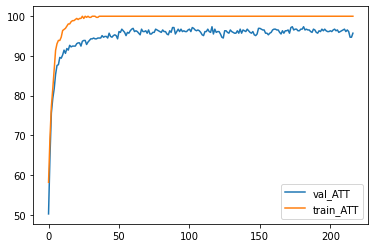

In [205]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

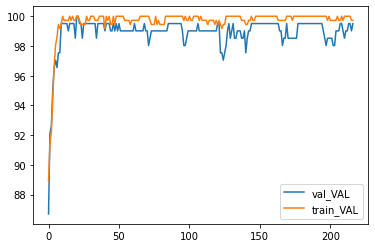

In [206]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

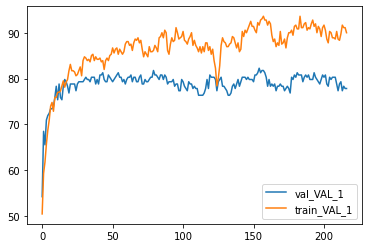

In [207]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

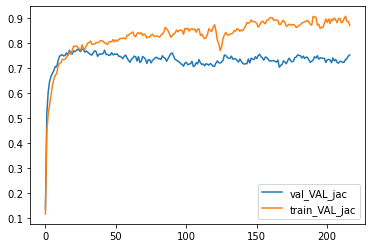

In [208]:
states[['val_VAL_jac','train_VAL_jac']].plot()

## Direct Prediction on VEN-XL

In [17]:
device = torch.device("cpu")
#device = torch.device("cpu")
print(device)

cpu


In [26]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset_XL = VEN_XL_Homo('dataset/Venice_XL_homo')
data_XL = dataset_XL[0]

In [27]:
data_XL.n_id = torch.arange(data_XL.num_nodes)
data_XL = data_XL.to(device)
data_XL

Data(num_nodes=80963, x=[80963, 1753], y=[80963, 20], att_lab=[80963], val_lab=[80963], node_type=[80963], train_mask=[80963], val_mask=[80963], test_mask=[80963], edge_index=[2, 290091503], edge_attr=[290091503], n_id=[80963])

In [28]:
model = GAT_L(dataset_XL.num_features, 256, dataset_XL.num_classes,
            heads=2, dropout=.1).to(device)

In [29]:
model.load_state_dict(torch.load(args.save_dir+'GAT_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [30]:
from torch_geometric.loader import NeighborLoader

In [215]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.train_mask,
)

In [216]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.val_mask,
)

In [217]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.test_mask,
)

In [31]:
unlabel_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data_XL.train_mask + data_XL.val_mask + data_XL.test_mask),
)

In [33]:
@torch.no_grad()
def predict_Homo(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch.n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [220]:
pred_train = predict_Homo(model, train_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [26:09<00:00,  4.34s/it]


In [221]:
pred_val = predict_Homo(model, val_loader)
#pred_test = predict_Homo(model, test_loader)
#pred_unlab = predict_Homo(model, unlabel_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [43:27<00:00,  4.18s/it]


In [222]:
#pred_val = predict_Homo(model, val_loader)
pred_test = predict_Homo(model, test_loader)
#pred_unlab = predict_Homo(model, unlabel_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [43:37<00:00,  4.19s/it]


In [34]:
pred_unlab = predict_Homo(model, unlabel_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 921/921 [1:02:41<00:00,  4.08s/it]


In [224]:
(~(data.train_mask + data.val_mask + data.test_mask))

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [225]:
pred_train[0]

tensor([4.0000e+00, 5.2877e-03, 8.9800e-01, 5.4645e-03, 2.0237e-03, 2.2924e-03,
        5.9337e-02, 9.0199e-03, 1.7338e-03, 1.6838e-02, 2.8692e-02, 9.9442e-02,
        1.8664e-01, 4.2723e-01, 1.1571e-01, 1.0448e-01, 7.7790e-03, 4.0255e-03,
        7.0834e-03, 8.1606e-03, 1.0753e-02])

In [177]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [226]:
preds = torch.vstack([pred_train, pred_val, pred_test]).cpu()

In [39]:
preds = torch.vstack([pred, pred_unlab]).cpu()

In [40]:
preds[:,1:].sum(axis=1)


tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
       dtype=torch.float64)

In [41]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [42]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.606621,0.042645,0.012985,0.019549,0.004886,0.256311,0.015131,0.014469,0.027402,0.239379,0.088697,0.135640,0.395381,0.033715,0.082694,0.005551,0.003396,0.003088,0.003626,0.008834
1.0,0.252455,0.009630,0.000875,0.002867,0.001045,0.721182,0.001338,0.001459,0.009149,0.212146,0.081509,0.119666,0.451611,0.028806,0.086718,0.003646,0.002293,0.002107,0.002652,0.008845
2.0,0.009880,0.191691,0.012672,0.010790,0.564881,0.020956,0.090688,0.006743,0.091698,0.099023,0.085721,0.125811,0.129485,0.035432,0.411415,0.045142,0.017808,0.014686,0.018913,0.016565
3.0,0.022011,0.239435,0.024383,0.018035,0.051965,0.186176,0.360085,0.016943,0.080967,0.046681,0.116083,0.210690,0.209185,0.074825,0.260412,0.026387,0.010870,0.015876,0.014159,0.014831
4.0,0.005288,0.898003,0.005465,0.002024,0.002292,0.059337,0.009020,0.001734,0.016838,0.028692,0.099442,0.186639,0.427228,0.115714,0.104485,0.007779,0.004025,0.007083,0.008161,0.010753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.071110,0.222845,0.012092,0.009293,0.008150,0.540893,0.037078,0.008469,0.090071,0.112130,0.258910,0.152992,0.334889,0.017436,0.098389,0.003754,0.004059,0.003721,0.004125,0.009595
80959.0,0.931158,0.017134,0.001273,0.018813,0.009902,0.007399,0.007012,0.005527,0.001782,0.246164,0.249971,0.178524,0.187882,0.010783,0.102800,0.003415,0.004380,0.003295,0.003330,0.009457
80960.0,0.832561,0.046017,0.001951,0.036893,0.006793,0.054922,0.010387,0.006642,0.003834,0.311779,0.129848,0.213426,0.163755,0.006383,0.152770,0.003210,0.003906,0.002351,0.003185,0.009385


In [43]:
preds_df.to_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t')

## Evaluation Metrics

In [44]:
preds = pd.read_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.606621,0.042645,0.012985,0.019549,0.004886,0.256311,0.015131,0.014469,0.027402,0.239379,0.088697,0.135640,0.395381,0.033715,0.082694,0.005551,0.003396,0.003088,0.003626,0.008834
1.0,0.252455,0.009630,0.000875,0.002867,0.001045,0.721182,0.001338,0.001459,0.009149,0.212146,0.081509,0.119666,0.451611,0.028806,0.086718,0.003646,0.002293,0.002107,0.002652,0.008845
2.0,0.009880,0.191691,0.012672,0.010790,0.564881,0.020956,0.090688,0.006743,0.091698,0.099023,0.085721,0.125811,0.129485,0.035432,0.411415,0.045142,0.017808,0.014686,0.018913,0.016565
3.0,0.022011,0.239435,0.024383,0.018035,0.051965,0.186176,0.360085,0.016943,0.080967,0.046681,0.116083,0.210690,0.209185,0.074825,0.260412,0.026387,0.010870,0.015876,0.014159,0.014831
4.0,0.005288,0.898003,0.005465,0.002024,0.002292,0.059337,0.009020,0.001734,0.016838,0.028692,0.099442,0.186639,0.427228,0.115714,0.104485,0.007779,0.004025,0.007083,0.008161,0.010753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.071110,0.222845,0.012092,0.009293,0.008150,0.540893,0.037078,0.008469,0.090071,0.112130,0.258910,0.152992,0.334889,0.017436,0.098389,0.003754,0.004059,0.003721,0.004125,0.009595
80959.0,0.931158,0.017134,0.001273,0.018813,0.009902,0.007399,0.007012,0.005527,0.001782,0.246164,0.249971,0.178524,0.187882,0.010783,0.102800,0.003415,0.004380,0.003295,0.003330,0.009457
80960.0,0.832561,0.046017,0.001951,0.036893,0.006793,0.054922,0.010387,0.006642,0.003834,0.311779,0.129848,0.213426,0.163755,0.006383,0.152770,0.003210,0.003906,0.002351,0.003185,0.009385


In [50]:
pred = torch.tensor(np.array(preds)).to(device)

In [51]:
eval_df = pd.DataFrame(('val_ATT_loss', 'val_VAL_loss', 'val_ATT_acc', 'val_VAL_acc', 'val_VAL_acc_k', 'val_VAL_jac_k'), columns=['name'])

In [55]:
train_ATT_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask][:,:9]).cpu().detach().item()
train_VAL_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask][:,9:]).cpu().detach().item()

train_ATT_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask][:,:9])
train_VAL_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask][:,9:])
train_VAL_acc_k = compute_k_accuracy(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask][:,9:].cpu(),3)
train_VAL_jac_k = compute_jaccard_index(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask][:,9:].cpu(),3)

In [56]:
eval_df['train'] = pd.DataFrame((train_ATT_loss, train_VAL_loss, train_ATT_acc, train_VAL_acc, train_VAL_acc_k, train_VAL_jac_k))

In [57]:
val_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9]).cpu().detach().item()
val_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:]).cpu().detach().item()

val_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9])
val_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:])
val_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)
val_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)

In [58]:
eval_df['val'] = pd.DataFrame((val_ATT_loss, val_VAL_loss, val_ATT_acc, val_VAL_acc, val_VAL_acc_k, val_VAL_jac_k))

In [59]:
test_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9]).cpu().detach().item()
test_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:]).cpu().detach().item()

test_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9])
test_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:])
test_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)
test_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)

In [60]:
eval_df['test'] = pd.DataFrame((test_ATT_loss, test_VAL_loss, test_ATT_acc, test_VAL_acc, test_VAL_acc_k, test_VAL_jac_k))

In [61]:
eval_df

,name,train,val,test
0,val_ATT_loss,1.753365,1.753401,1.754944
1,val_VAL_loss,2.246282,2.243725,2.243127
2,val_ATT_acc,93.318351,96.277877,96.008093
3,val_VAL_acc,80.041490,80.879865,80.900141
4,val_VAL_acc_k,98.470049,98.716864,98.607595
5,val_VAL_jac_k,0.740859,0.735030,0.734388


In [62]:
eval_df.to_csv(args.save_dir+'eval_metrics_XL_trans.csv')

## Per-Class Metrics

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [66]:
test_ATT_conf = confusion_matrix(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9].argmax(axis=1).cpu())
test_VAL_conf = confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)).astype(int)

In [67]:
test_ATT_conf

array([[1330,   15,    0,    4,    2,   33,    5,    0,    0],
       [   0, 3187,    0,    0,    1,   12,   11,    0,    0],
       [   0,    0,  230,    0,    0,    0,   33,    2,    0],
       [  56,    9,    0,  543,    1,    1,   27,    0,    0],
       [   5,    8,    0,    0, 2686,    0,    5,    0,    0],
       [   5,   14,    0,    0,    4, 1559,    1,    0,    0],
       [   2,   27,    0,    0,    9,    0, 2555,    0,    0],
       [   4,    6,   36,    9,    0,    0,  144,  114,    0],
       [   0,    6,    0,    0,   13,    3,    0,    0,  134]],
      dtype=int64)

In [68]:
test_VAL_conf

array([[ 608,    1,   23,    6,    0,   42,    0,    0,    0,    0,    0],
       [  69,  418,  130,   75,    0,  157,    0,    0,    0,    0,    0],
       [  49,   18, 1143,   58,    0,  339,    0,    0,    0,    0,    0],
       [  37,    5,   38,  369,    0,   87,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  36,    5,  149,   24,    0, 3200,    1,    0,    0,    0,    0],
       [   1,    0,    0,    0,    0,    3,    6,    0,    0,    2,    0],
       [   0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    1,    0,    0,    8,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [69]:
test_VAL_conf_k

array([[1432,  488, 1245,  809,    0,  975,    4,    0,    0,    0,    0],
       [ 972, 1178, 2348, 1844,    9, 1857,    0,    0,    0,    0,    0],
       [1035,  844, 5875, 4985,   10, 5328,    6,    0,    0,    1,    0],
       [ 909,  843, 4856, 4774,   12, 4410,    0,    0,    0,    0,    0],
       [   0,    3,   18,   18,    5,   10,    0,    0,    0,    0,    0],
       [ 883,  424, 5357, 4623,    0, 5377,    5,    1,    0,    1,    0],
       [   8,    0,   16,    7,    0,   17,   22,    2,    7,   17,    0],
       [   1,    0,    0,    2,    0,    4,    6,    1,    2,    5,    0],
       [   2,    0,    3,    1,    0,    2,   14,    1,    5,   14,    0],
       [   2,    0,    4,    1,    0,    5,   18,    1,    7,   19,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [70]:
data_XL.val_mask[data_XL.val_mask + data_XL.train_mask]

tensor([ True,  True, False,  ...,  True,  True,  True])

In [71]:
val_ATT_conf = confusion_matrix(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)).astype(int)

In [72]:
val_ATT_conf

array([[1314,    3,    0,    2,    3,   27,    3,    0,    0],
       [   1, 3269,    0,    0,    0,   14,   15,    0,    0],
       [   0,    0,  259,    0,    0,    0,   20,    1,    0],
       [  73,   11,    0,  570,    0,    2,   23,    1,    0],
       [   1,    6,    0,    0, 2677,    0,    3,    0,    0],
       [   4,   15,    0,    1,    3, 1464,    1,    0,    0],
       [   1,   23,    0,    0,   12,    0, 2594,    0,    0],
       [   7,    4,   24,    8,    0,    2,  141,  100,    0],
       [   0,    6,    0,    0,   15,    3,    0,    0,  143]],
      dtype=int64)

In [73]:
val_VAL_conf

array([[ 594,    5,   15,   15,    0,   38,    0,    0,    0,    0,    0],
       [  88,  416,  110,   87,    0,  128,    0,    0,    0,    0,    0],
       [  50,   13, 1164,   68,    0,  348,    0,    0,    0,    1,    0],
       [  51,    7,   42,  416,    0,   82,    0,    0,    0,    0,    0],
       [   0,    0,    0,    3,    1,    0,    0,    0,    0,    0,    0],
       [  29,    7,  143,   18,    0, 3135,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    5,    0,    0,    0,    0],
       [   1,    0,    0,    0,    0,    0,    1,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    3,    0,    0,    5,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [74]:
val_VAL_conf_k

array([[1462,  481, 1230,  835,    1, 1006,    1,    0,    0,    0,    0],
       [1028, 1169, 2426, 1963,    7, 1939,    3,    0,    0,    0,    0],
       [1052,  850, 5833, 4922,    8, 5290,   14,    0,    0,    1,    0],
       [ 915,  855, 4755, 4701,   13, 4325,    3,    0,    0,    0,    0],
       [   0,    5,   20,   21,    9,   10,    0,    0,    0,    1,    0],
       [ 871,  407, 5268, 4579,    1, 5304,   15,    0,    0,    1,    0],
       [  11,    1,   24,   14,    2,   31,   21,    0,    3,   13,    0],
       [   1,    0,    1,    1,    0,    2,    2,    0,    0,    2,    0],
       [   3,    0,    5,    1,    1,    7,   14,    0,    3,   14,    0],
       [   3,    0,    7,    3,    0,    8,   14,    0,    3,   13,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [75]:
train_ATT_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,:9].argmax(axis=1).cpu(), 
                                  pred[data_XL.train_mask][:,:9].argmax(axis=1).cpu())
train_VAL_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
train_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                                pred[data_XL.train_mask][:,9:].cpu(),3)).astype(int)

In [76]:
train_ATT_conf

array([[1460,   12,    0,    2,    0,   22,    5,    0,    0],
       [   1, 2619,    0,    0,    0,    8,    8,    0,    0],
       [   2,    2,  108,    0,    0,    0,   27,    0,    0],
       [  48,   18,    0,  394,    1,    2,   16,    1,    0],
       [   4,    7,    0,    0, 2032,    0,    8,    0,    0],
       [   4,   26,    0,    0,    4, 1473,    0,    0,    0],
       [   1,   54,    0,    2,   11,    0, 2388,    1,    0],
       [  24,   13,    8,   14,    0,    0,  397,  229,    0],
       [   0,   11,    0,    0,    6,    3,    0,    0,   93]],
      dtype=int64)

In [77]:
train_VAL_conf

array([[ 885,    7,   33,   12,    0,   75,    0,    0,    0,    0,    0],
       [ 105,  640,  250,  138,    0,  245,    0,    0,    0,    0,    0],
       [  64,   21, 2028,   81,    0,  621,    0,    0,    0,    0,    0],
       [  45,   11,   77,  788,    0,  122,    0,    0,    0,    0,    0],
       [   0,    0,    0,    2,    0,    0,    0,    0,    0,    0,    0],
       [  60,   10,  270,   49,    0, 4894,    0,    0,    0,    0,    0],
       [   2,    0,    0,    0,    0,    3,   15,    0,    0,    1,    0],
       [   1,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    2,    0,    0,   10,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [78]:
train_VAL_conf_k

array([[2132,  714, 1777, 1222,    0, 1539,    3,    0,    0,    2,    0],
       [1432, 1950, 4056, 3382,    9, 3282,    1,    0,    0,    0,    0],
       [1593, 1456, 9605, 8151,   12, 8765,   10,    0,    0,    0,    0],
       [1451, 1412, 7884, 7780,   20, 7186,    1,    0,    0,    0,    0],
       [   0,   13,   50,   53,   18,   28,    0,    0,    0,    0,    0],
       [1366,  695, 8553, 7464,    1, 8671,   12,    0,    0,    1,    0],
       [  19,    0,   25,   14,    0,   38,   39,    1,    9,   29,    0],
       [  10,    0,    3,    1,    0,   11,   15,    0,    2,   12,    0],
       [   3,    0,    2,    0,    0,    7,   19,    1,    7,   18,    0],
       [   7,    0,    4,    1,    0,   11,   26,    1,    9,   25,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [79]:
pd.concat([pd.DataFrame(train_ATT_conf),pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf),pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf_k),pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k_XL_trans.csv')

In [80]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [81]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [82]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [83]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [84]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [85]:
metrics_df

precision    recall  \
test_ATT  Building Elements                         0.957523  0.948645   
          Urban Form Elements                       0.992526  0.974022   
          Gastronomy                                0.867925  0.864662   
          Interior Scenery                          0.852433  0.976619   
          Natural Features and Land-scape Scenery   0.993343  0.988954   
...                                                      ...       ...   
val_VAL_k Criterion vii                             0.525000  0.724138   
          Criterion viii                            0.000000  0.000000   
          Criterion ix                              0.187500  1.000000   
          Criterion x                               0.764706  0.866667   
          Others                                    0.000000  0.000000   

                                                         F1  
test_ATT  Building Elements                        0.953063  
          Urban Form Elements                      0.983187  
          Gastronomy                               0.866290  
          Interior Scenery                         0.910310  
          Natural Features and Land-scape Scenery  0.991144  
...                                                     ...  
val_VAL_k Criterion vii                            0.608696  
          Criterion viii                           0.000000  
          Criterion ix                             0.315789  
          Criterion x                              0.812500  
          Others                                   0.000000  

[62 rows x 3 columns]

In [86]:
metrics_df.to_csv(args.save_dir+'per_class_metrics_XL_trans.csv')